In [1]:
! pip install ta

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# For prepare data
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import ta
from ta import add_all_ta_features
from ta.momentum import RSIIndicator, StochasticOscillator, WilliamsRIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.trend import MACD, ADXIndicator

from tqdm import tqdm

# For modeling
import math
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
# from pytorch_optimizer import SAM

# Prepare data

In [3]:
# 1. Hàm load data
def load_data(file_path):
    df = pd.read_csv(file_path)
    # Xử lý datetime
    df['Datetime'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Datetime').drop(['Date'], axis=1)
    return df

train_df = load_data("data/xauusd/1m/dynamic_labeled_train.csv")
val_df = load_data("data/xauusd/1m/dynamic_labeled_dev.csv")
test_df = load_data("data/xauusd/1m/dynamic_labeled_test.csv")

# train_df = train_df.loc[train_df['Datetime'].dt.year.isin(range(2018, 2021))]

train_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Label', 'Datetime'], dtype='object')

In [4]:
label_mapping = {
    'BUY': 0,
    'SELL': 1,
    'HOLD': 2
}

def map_label(x):
    return label_mapping[x] if x in label_mapping else x

# train_df['Label'] = train_df['Label'].map(map_label)
# val_df['Label'] = val_df['Label'].map(map_label)
# test_df['Label'] = test_df['Label'].map(map_label)

In [5]:
# 2. Hàm thêm basic features
def add_basic_features(df):
    df['Price_Spread'] = df['High'] - df['Low']
    df['Price_Change'] = df['Close'] - df['Open']
    df['Body_Ratio'] = (df['Close'] - df['Open']) / (df['Price_Spread'] + 1e-8)
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    
    df['Cumulative_Return_5D'] = np.exp(df['Log_Return'].rolling(5).sum()) - 1  # Lũy kế 5 ngày
    
    return df

train_df = add_basic_features(train_df)
val_df = add_basic_features(val_df)
test_df = add_basic_features(test_df)
    
train_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Label', 'Datetime',
       'Price_Spread', 'Price_Change', 'Body_Ratio', 'Log_Return',
       'Cumulative_Return_5D'],
      dtype='object')

In [ ]:
# 3. Hàm thêm technical indicators
def add_technical_indicators(df):
    df = df.copy()

    # RSI
    df['RSI_14'] = ta.momentum.RSIIndicator(close=df['Close']).rsi()

    # MACD
    macd = ta.trend.MACD(close=df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

    # Bollinger Bands
    bb = ta.volatility.BollingerBands(close=df['Close'])
    df['BB_Upper'] = bb.bollinger_hband()
    df['BB_Lower'] = bb.bollinger_lband()

    # Average True Range (ATR)
    df['ATR'] = ta.volatility.AverageTrueRange(
        high=df['High'], low=df['Low'], close=df['Close']
    ).average_true_range()

    # ADX
    df['ADX'] = ta.trend.ADXIndicator(
        high=df['High'], low=df['Low'], close=df['Close']
    ).adx()
    df['Market_Trend'] = (df['ADX'] > 25).astype(int)

    # On-Balance Volume (OBV)
    df['OBV'] = ta.volume.OnBalanceVolumeIndicator(
        close=df['Close'], volume=df['Volume']
    ).on_balance_volume()

    # Stochastic Oscillator
    stoch = ta.momentum.StochasticOscillator(
        high=df['High'], low=df['Low'], close=df['Close']
    )
    df['Stoch_%K'] = stoch.stoch()
    df['Stoch_%D'] = stoch.stoch_signal()

    # Williams %R
    df['Williams_%R'] = ta.momentum.WilliamsRIndicator(
        high=df['High'], low=df['Low'], close=df['Close'], lbp=14
    ).williams_r()

    # Custom: Volume-Weighted Momentum
    df['VW_Momentum'] = (df['Volume'] * (df['Close'] - df['Close'].shift(1))).rolling(5).sum()

    # Custom: Kết hợp RSI và MACD Histogram
    df['RSI_MACD_Interaction'] = df['RSI_14'] * df['MACD_Histogram']

    # Custom: Tương quan Volume-Giá
    df['Volume_Price_Correlation'] = df['Volume'].rolling(10).corr(df['Close'])

    return df

train_df = add_technical_indicators(train_df)
val_df = add_technical_indicators(val_df)
test_df = add_technical_indicators(test_df)

train_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Label', 'Datetime',
       'Price_Spread', 'Price_Change', 'Body_Ratio', 'Log_Return',
       'Cumulative_Return_5D', 'RSI_14', 'MACD', 'MACD_Signal',
       'MACD_Histogram', 'BB_Upper', 'BB_Lower', 'ATR', 'ADX', 'Market_Trend',
       'OBV', 'Stoch_%K', 'Stoch_%D', 'Williams_%R', 'VW_Momentum',
       'RSI_MACD_Interaction', 'Volume_Price_Correlation'],
      dtype='object')

In [7]:
# 4. Hàm thêm statistical features
def add_statistical_features(df, window=20):
    df['Rolling_Mean'] = df['Close'].rolling(window).mean()
    df['Rolling_Std'] = df['Close'].rolling(window).std()
    df['Rolling_Max'] = df['High'].rolling(window).max()
    df['Rolling_Min'] = df['Low'].rolling(window).min()
    
    # Biến động "nén" trong ngắn hạn
    df['Volatility_Clustering'] = df['Rolling_Std'] / df['Rolling_Std'].shift(5)
    
    df['Rolling_Skew'] = df['Close'].rolling(window).skew()
    df['Rolling_Kurtosis'] = df['Close'].rolling(window).kurt()
    df['Rolling_Q80'] = df['Close'].rolling(window).quantile(0.8)
    df['Rolling_Q20'] = df['Close'].rolling(window).quantile(0.2)
    df['Quantile_Spread'] = df['Rolling_Q80'] - df['Rolling_Q20']  # Độ phân tán phân vị
    
    return df

train_df = add_statistical_features(train_df)
val_df = add_statistical_features(val_df)
test_df = add_statistical_features(test_df)

train_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Label', 'Datetime',
       'Price_Spread', 'Price_Change', 'Body_Ratio', 'Log_Return',
       'Cumulative_Return_5D', 'RSI_14', 'MACD', 'MACD_Signal',
       'MACD_Histogram', 'BB_Upper', 'BB_Lower', 'ATR', 'ADX', 'Market_Trend',
       'OBV', 'Stoch_%K', 'Stoch_%D', 'Williams_%R', 'VW_Momentum',
       'RSI_MACD_Interaction', 'Volume_Price_Correlation', 'Rolling_Mean',
       'Rolling_Std', 'Rolling_Max', 'Rolling_Min', 'Volatility_Clustering',
       'Rolling_Skew', 'Rolling_Kurtosis', 'Rolling_Q80', 'Rolling_Q20',
       'Quantile_Spread'],
      dtype='object')

In [8]:
# 5. Hàm thêm time-based features
def add_time_features(df, threshold=10):
    df['Hour'] = df['Datetime'].dt.hour
    df['DayOfWeek'] = df['Datetime'].dt.dayofweek
    df['Minute'] = df['Datetime'].dt.hour * 60 + df['Datetime'].dt.minute
    
    df['Timedelta'] = df['Datetime'].diff().dt.total_seconds().div(60).fillna(0)
    df['Is_big_delta'] = (df['Timedelta'] > threshold).astype(int)
    
    return df

train_df = add_time_features(train_df)
val_df = add_time_features(val_df)
test_df = add_time_features(test_df)

train_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Label', 'Datetime',
       'Price_Spread', 'Price_Change', 'Body_Ratio', 'Log_Return',
       'Cumulative_Return_5D', 'RSI_14', 'MACD', 'MACD_Signal',
       'MACD_Histogram', 'BB_Upper', 'BB_Lower', 'ATR', 'ADX', 'Market_Trend',
       'OBV', 'Stoch_%K', 'Stoch_%D', 'Williams_%R', 'VW_Momentum',
       'RSI_MACD_Interaction', 'Volume_Price_Correlation', 'Rolling_Mean',
       'Rolling_Std', 'Rolling_Max', 'Rolling_Min', 'Volatility_Clustering',
       'Rolling_Skew', 'Rolling_Kurtosis', 'Rolling_Q80', 'Rolling_Q20',
       'Quantile_Spread', 'Hour', 'DayOfWeek', 'Minute', 'Timedelta',
       'Is_big_delta'],
      dtype='object')

In [9]:
def drop_na_cols(df, threshold=0.01):
    cnt = 0
    for col in df.columns:
        na = df[[col]].isna().sum()
        if na.values > len(df) * threshold:
            df.drop(col, axis=1, inplace=True)
            cnt += 1
    print(f'Deleted {cnt} cols')
    return df

# 6. Hàm xử lý missing values
def handle_missing_data(df, threshold=0.01):
    df = drop_na_cols(df, threshold)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Xóa các hàng có NaN sinh ra bởi indicators
    # print(df.isna().sum())
    df = df.dropna()
    # # Forward fill cho các features nhất định
    # df.loc[:, ['Volume', 'Open']] = df[['Volume', 'Open']].ffill()
    return df

# train_df
train_df = handle_missing_data(train_df)
val_df = handle_missing_data(val_df)
test_df = handle_missing_data(test_df)
train_df.columns

Deleted 0 cols
Deleted 0 cols
Deleted 0 cols


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Label', 'Datetime',
       'Price_Spread', 'Price_Change', 'Body_Ratio', 'Log_Return',
       'Cumulative_Return_5D', 'RSI_14', 'MACD', 'MACD_Signal',
       'MACD_Histogram', 'BB_Upper', 'BB_Lower', 'ATR', 'ADX', 'Market_Trend',
       'OBV', 'Stoch_%K', 'Stoch_%D', 'Williams_%R', 'VW_Momentum',
       'RSI_MACD_Interaction', 'Volume_Price_Correlation', 'Rolling_Mean',
       'Rolling_Std', 'Rolling_Max', 'Rolling_Min', 'Volatility_Clustering',
       'Rolling_Skew', 'Rolling_Kurtosis', 'Rolling_Q80', 'Rolling_Q20',
       'Quantile_Spread', 'Hour', 'DayOfWeek', 'Minute', 'Timedelta',
       'Is_big_delta'],
      dtype='object')

In [10]:
# 7. Hàm chuẩn hóa dữ liệu (Áp dụng riêng cho từng tập)
def scale_features(train_df, val_df, test_df, excepts=['Label', 'Datetime']):
    # Chọn các cột cần chuẩn hóa (bỏ các cột không phải số)
    feature_columns = [col for col in train_df.columns if col not in excepts]
    
    # Chuẩn hóa theo train
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_df[feature_columns])
    val_scaled = scaler.transform(val_df[feature_columns])
    test_scaled = scaler.transform(test_df[feature_columns])
    
    # Tạo DataFrame mới đã scaled
    scaled_train_df = pd.DataFrame(train_scaled, columns=feature_columns, index=train_df.index)
    scaled_val_df = pd.DataFrame(val_scaled, columns=feature_columns, index=val_df.index)
    scaled_test_df = pd.DataFrame(test_scaled, columns=feature_columns, index=test_df.index)
    
    # Thêm lại các cột không phải feature
    for scaled_df, df in zip([scaled_train_df, scaled_val_df, scaled_test_df], [train_df, val_df, test_df]):
        for col in excepts:
            scaled_df[col] = df[col].values
    
    return scaled_train_df, scaled_val_df, scaled_test_df

train_df, val_df, test_df = scale_features(train_df, val_df, test_df, excepts=['Label', 'Datetime'])
train_df

,Open,High,Low,Close,Volume,Price_Spread,Price_Change,Body_Ratio,Log_Return,Cumulative_Return_5D,...,Rolling_Q80,Rolling_Q20,Quantile_Spread,Hour,DayOfWeek,Minute,Timedelta,Is_big_delta,Label,Datetime
33,0.035142,0.036373,-0.034977,-0.025288,46.905413,34.259750,-33.248019,-1.351639,-33.995909,-16.086466,...,0.071453,0.036180,7.733276,0.318718,-0.705695,0.243886,1.554519,33.177317,BUY,2011-01-04 13:00:00
34,-0.025152,-0.017908,-0.070186,-0.060532,48.400330,25.089422,-19.466032,-1.068992,-20.004817,-22.064913,...,0.069895,0.032468,8.203713,0.470623,-0.705695,0.395695,1.554519,33.177317,BUY,2011-01-04 14:00:00
35,-0.060627,-0.055356,-0.087444,-0.082399,53.527525,15.387480,-11.978580,-1.049715,-12.466926,-28.799502,...,0.067700,0.030917,8.062380,0.622528,-0.705695,0.547503,1.554519,33.177317,BUY,2011-01-04 15:00:00
36,-0.082263,-0.070760,-0.083245,-0.074464,36.984599,5.973495,4.290764,0.906233,4.528357,-26.972465,...,0.066280,0.017236,10.743673,0.774433,-0.705695,0.699311,1.554519,33.177317,SELL,2011-01-04 16:00:00
37,-0.074144,-0.071082,-0.118961,-0.113169,47.103088,22.962969,-21.471146,-1.285842,-22.144231,-38.016898,...,0.063034,-0.030365,20.443170,0.926338,-0.705695,0.851119,1.554519,33.177317,HOLD,2011-01-04 17:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3446544,2.261498,2.264532,2.261847,2.266113,0.488854,1.919944,2.539462,1.305284,1.925878,-1.101240,...,2.274095,2.272118,1.036100,1.230147,0.693552,1.187627,-0.013949,-0.030141,SELL,2020-12-31 19:13:00
3446545,2.266111,2.267437,2.267708,2.267359,0.056440,0.502308,0.686635,0.714170,0.519577,-0.388418,...,2.274095,2.270493,1.391452,1.230147,0.693552,1.190158,-0.013949,-0.030141,BUY,2020-12-31 19:14:00
3446546,2.266942,2.265454,2.267200,2.266159,-0.054753,-0.206509,-0.430138,-0.895212,-0.500965,0.668597,...,2.274095,2.269533,1.601433,1.230147,0.693552,1.192688,-0.013949,-0.030141,BUY,2020-12-31 19:15:00
3446547,2.266157,2.264762,2.265031,2.263438,0.031730,0.502308,-1.496148,-1.534578,-1.136651,0.131128,...,2.274095,2.268960,1.726614,1.230147,0.693552,1.195218,-0.013949,-0.030141,BUY,2020-12-31 19:16:00


In [11]:
def compute_corr(df, start_dt=None, end_dt=None):
    df = df.copy()
    if start_dt and end_dt:
        start_dt = pd.to_datetime(start_dt)
        end_dt = pd.to_datetime(end_dt)
        df = df[(df['Datetime'] >= start_dt) & (df['Datetime'] <= end_dt)]
    
    buy = df.loc[df['Label'] == 'BUY']
    sell = df.loc[df['Label'] == 'SELL']

    print(f"Số lượng mẫu của BUY và SELL: {len(buy)}, {len(sell)}")

    # Bỏ cột Label nếu có
    buy_features = buy.drop(columns=['Label', 'Datetime'])
    sell_features = sell.drop(columns=['Label', 'Datetime'])

    # Tính correlation giữa trung bình của buy và sell
    correlation = buy_features.mean().corr(sell_features.mean())
    print("Correlation between mean features of BUY and SELL:", correlation)

    # Cần align số hàng nếu không bằng nhau (cắt bằng chiều ngắn nhất)
    min_len = min(len(buy_features), len(sell_features))
    buy_aligned = buy_features.iloc[:min_len].reset_index(drop=True)
    sell_aligned = sell_features.iloc[:min_len].reset_index(drop=True)

    # Tính Pearson correlation cho từng cột
    feature_corrs = buy_aligned.corrwith(sell_aligned)
    print(feature_corrs)
    
print('====================================================')
print('Train set:')
compute_corr(train_df)

print('====================================================')
print('Val set:')
compute_corr(val_df)

print('====================================================')
print('Train set:')
compute_corr(test_df)

Train set:
Số lượng mẫu của BUY và SELL: 1100889, 735101
Correlation between mean features of BUY and SELL: -0.520649378561729
Open                        0.320420
High                        0.320442
Low                         0.320418
Close                       0.320436
Volume                     -0.007958
Price_Spread                0.020064
Price_Change               -0.003484
Body_Ratio                 -0.001262
Log_Return                 -0.002426
Cumulative_Return_5D       -0.000849
RSI_14                      0.000628
MACD                        0.004712
MACD_Signal                 0.004160
MACD_Histogram             -0.001942
BB_Upper                    0.320658
BB_Lower                    0.320077
ATR                         0.047425
ADX                        -0.001903
Market_Trend               -0.000080
OBV                         0.995303
Stoch_%K                   -0.000178
Stoch_%D                    0.000352
Williams_%R                -0.000178
VW_Momentum           

In [12]:
start_dt = '2018-11-20 10:00:00'
end_dt = '2018-11-20 12:00:00'

compute_corr(train_df, start_dt, end_dt)

Số lượng mẫu của BUY và SELL: 32, 41
Correlation between mean features of BUY and SELL: 0.46957843604409916
Open                       -0.371007
High                       -0.323268
Low                        -0.412435
Close                      -0.343837
Volume                      0.047182
Price_Spread                0.105304
Price_Change                0.076460
Body_Ratio                  0.086192
Log_Return                  0.075626
Cumulative_Return_5D       -0.112226
RSI_14                      0.106547
MACD                        0.106363
MACD_Signal                 0.136501
MACD_Histogram             -0.221451
BB_Upper                    0.088316
BB_Lower                   -0.145406
ATR                         0.037237
ADX                        -0.397409
Market_Trend                0.046374
OBV                        -0.030908
Stoch_%K                    0.002186
Stoch_%D                   -0.016771
Williams_%R                 0.002186
VW_Momentum                 0.047140
RSI_

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

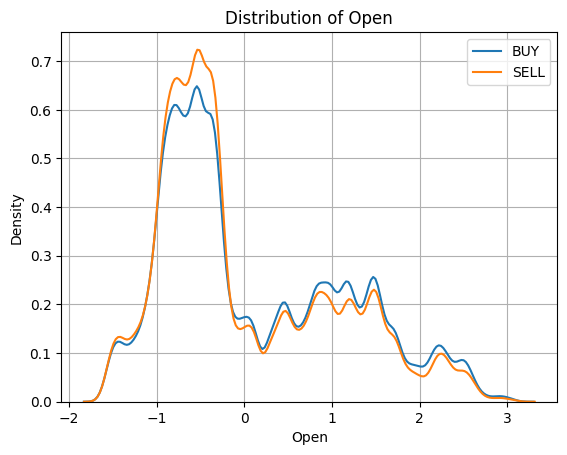

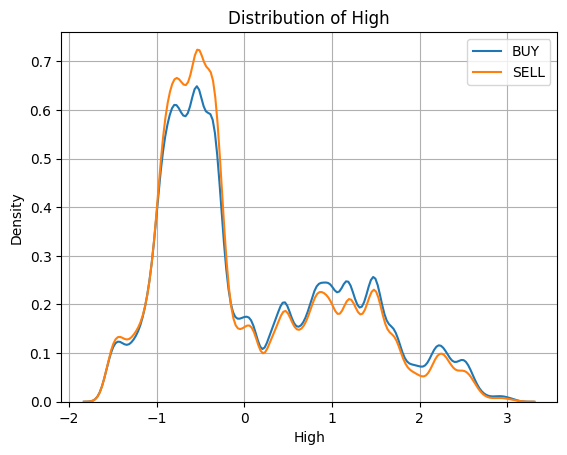

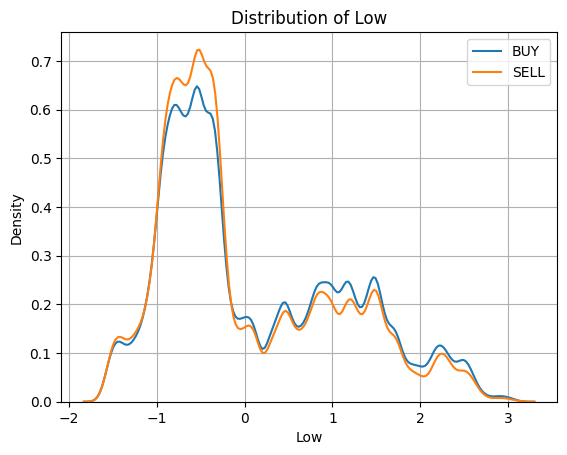

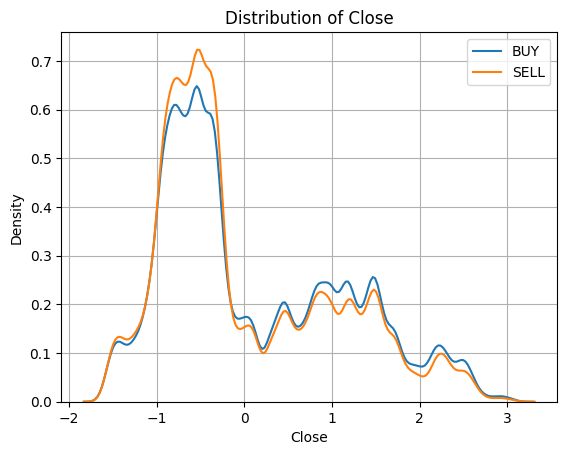

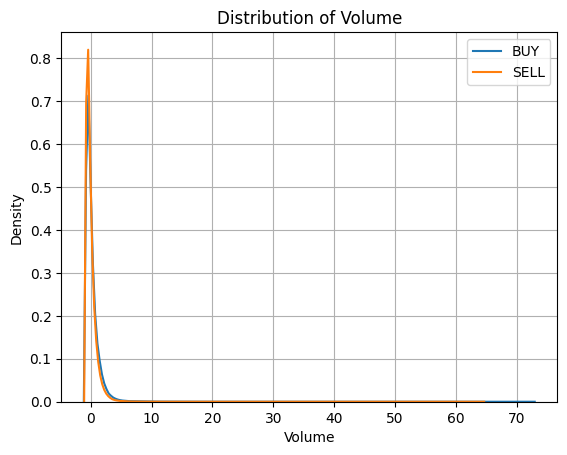

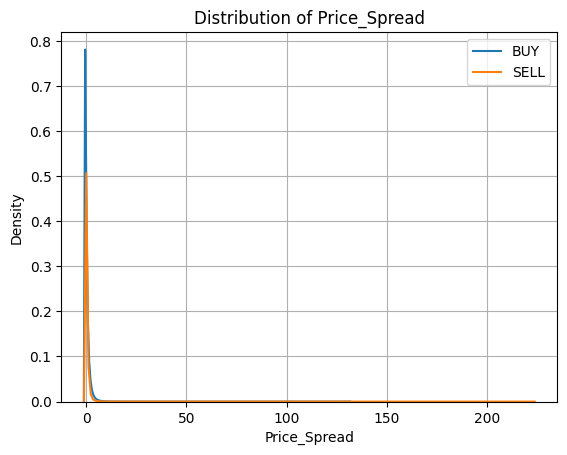

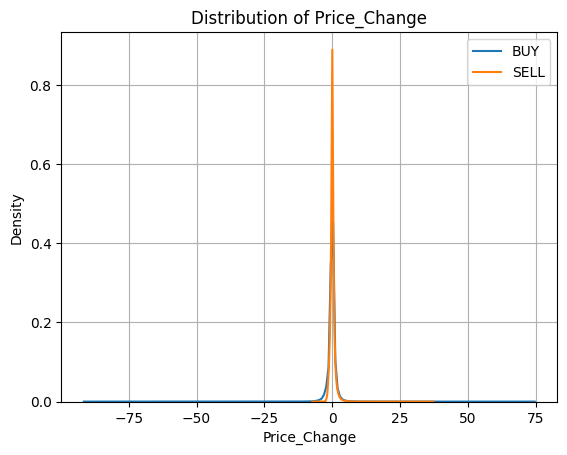

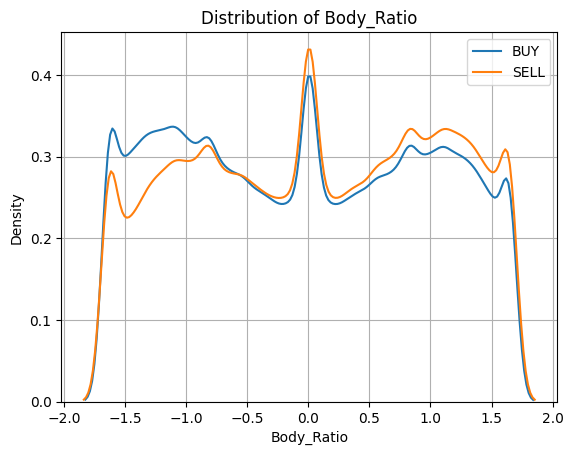

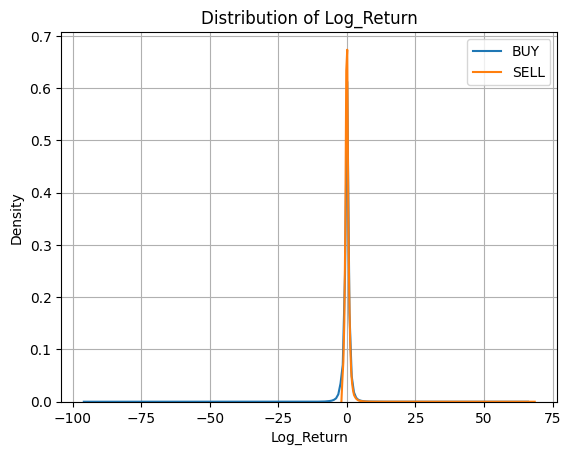

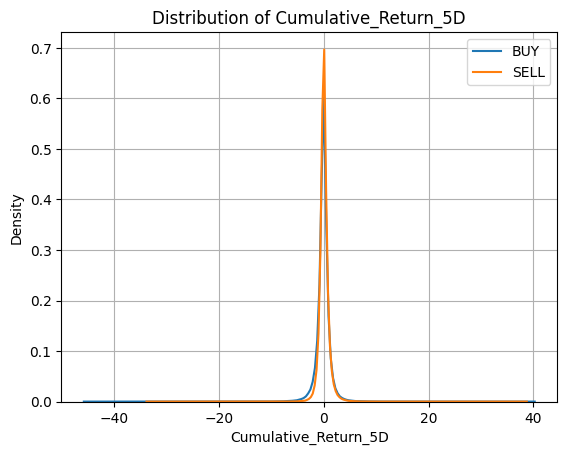

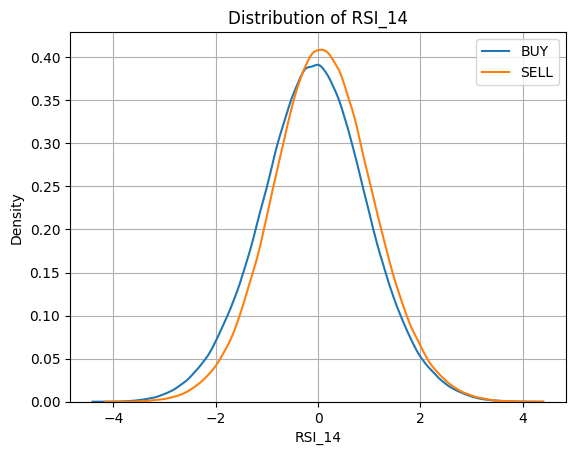

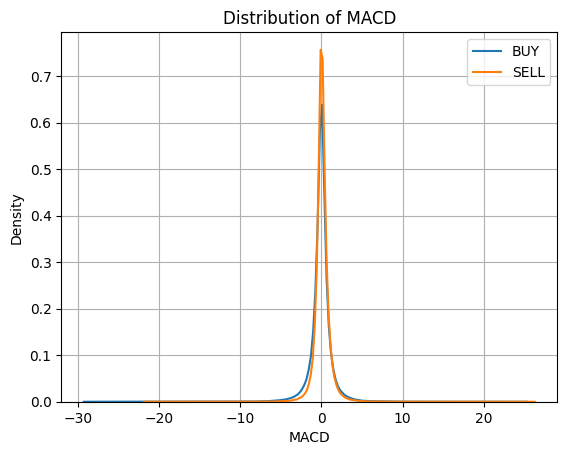

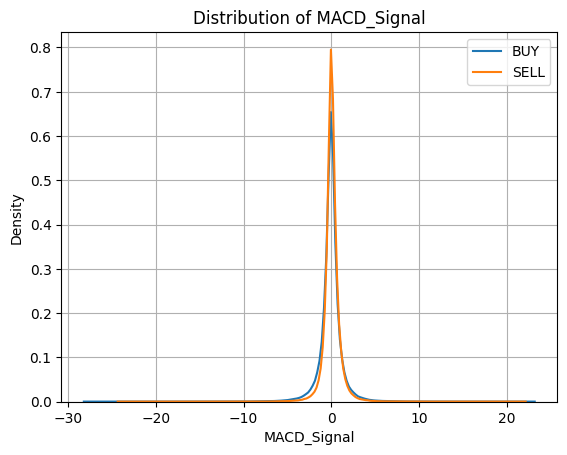

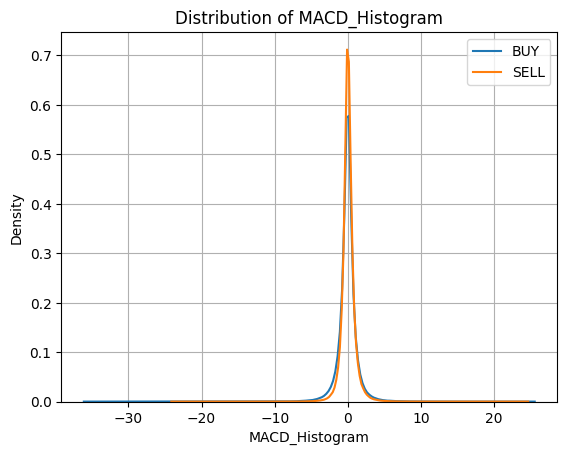

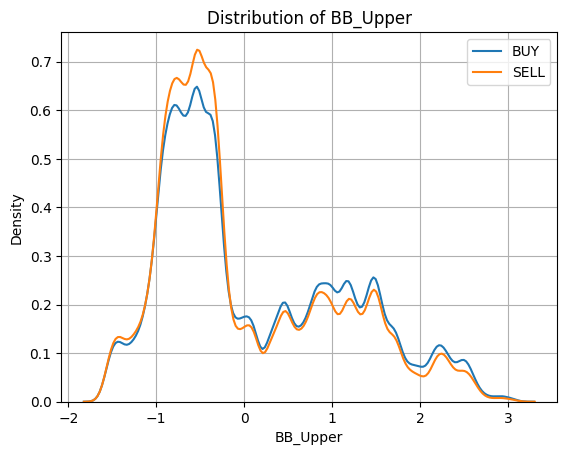

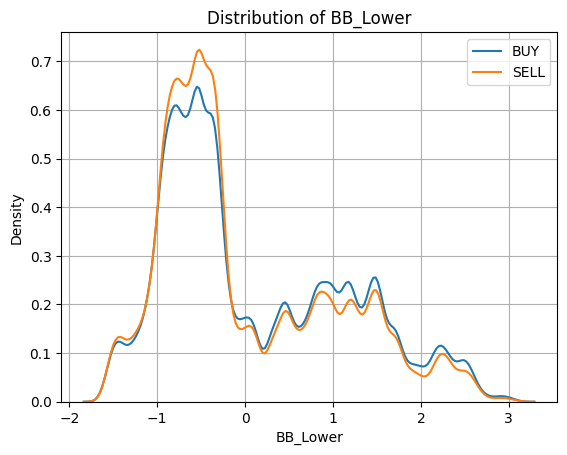

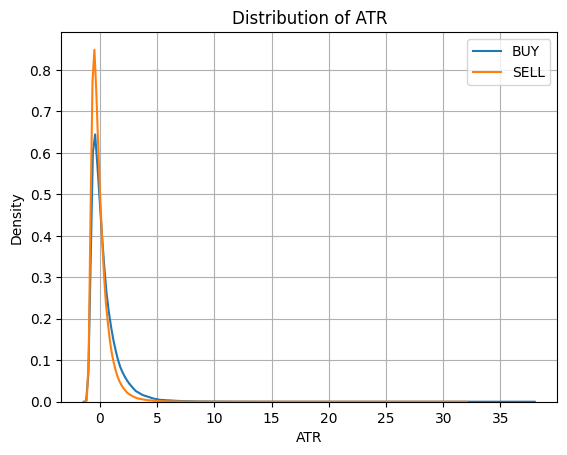

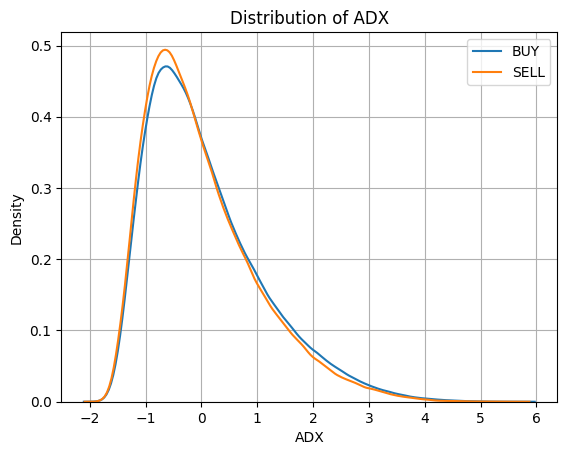

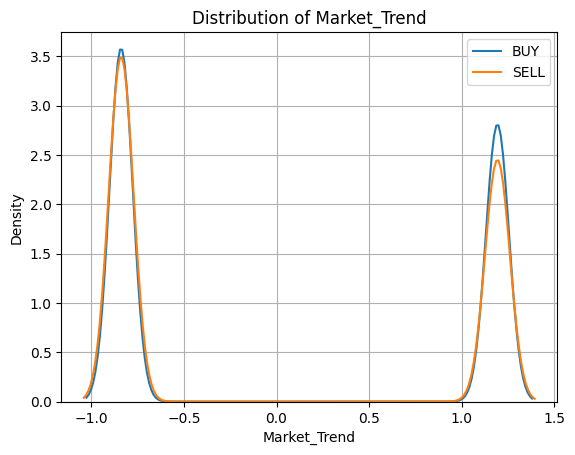

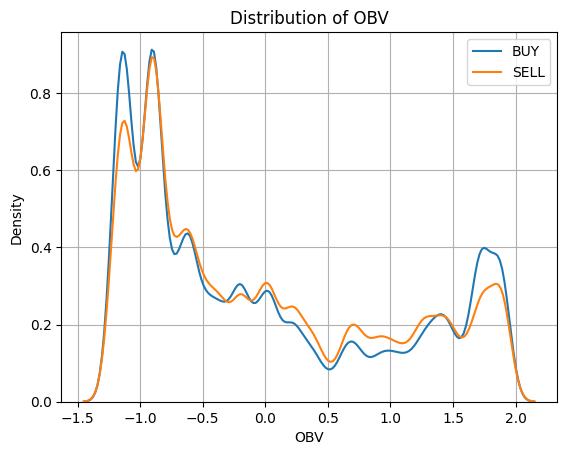

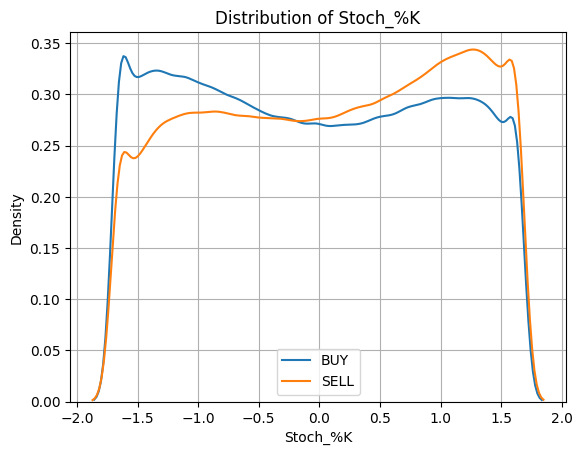

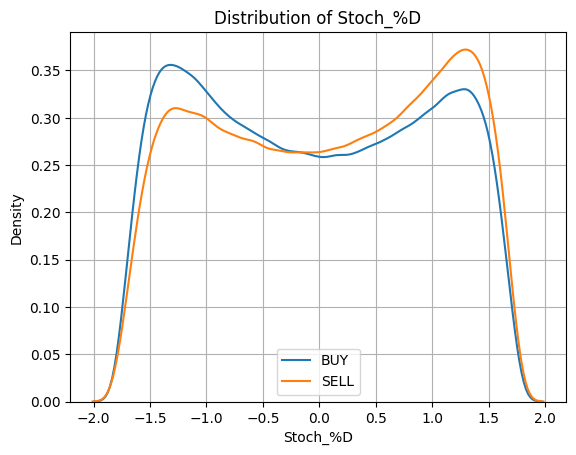

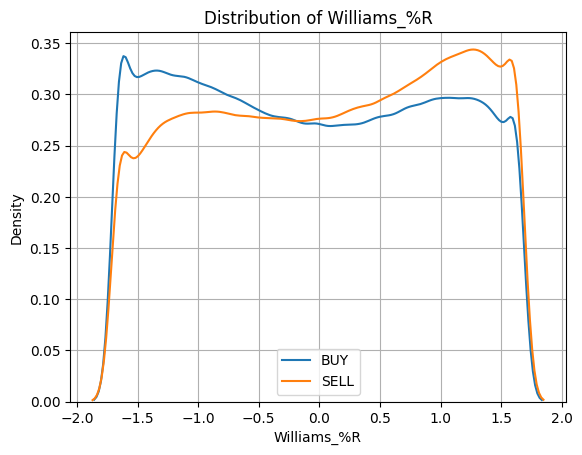

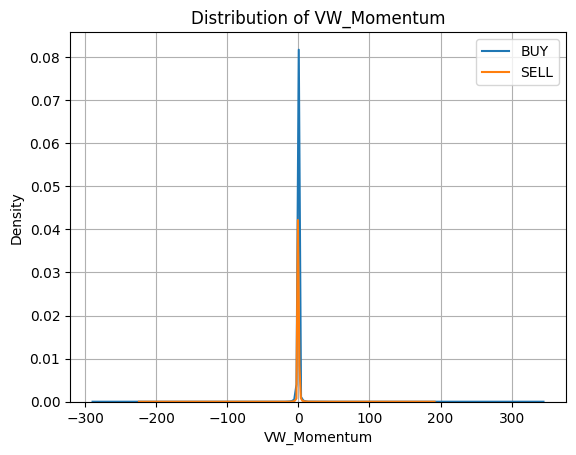

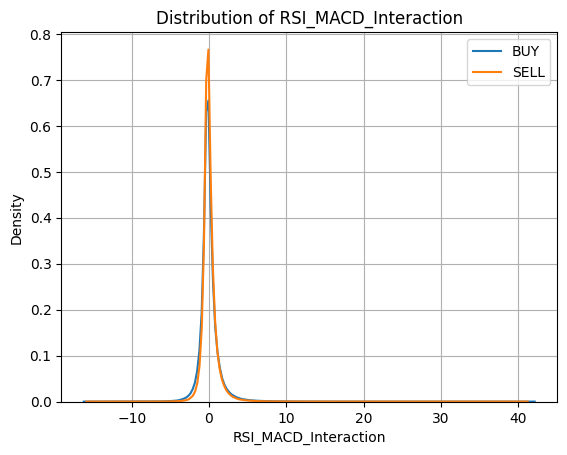

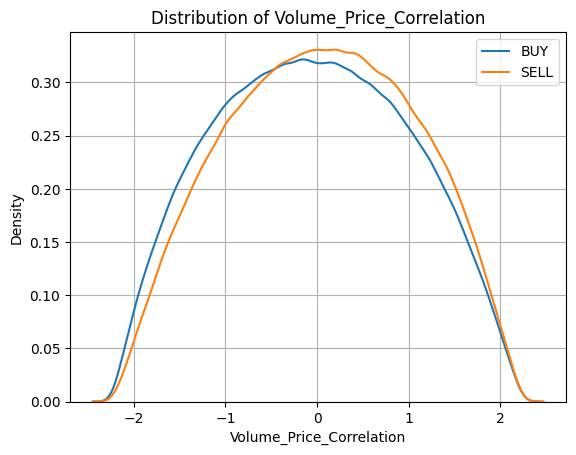

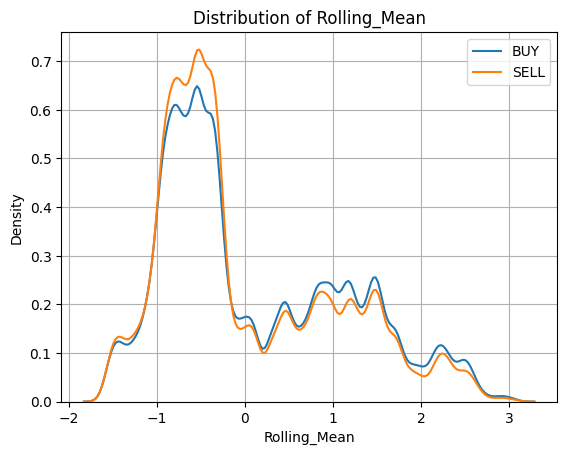

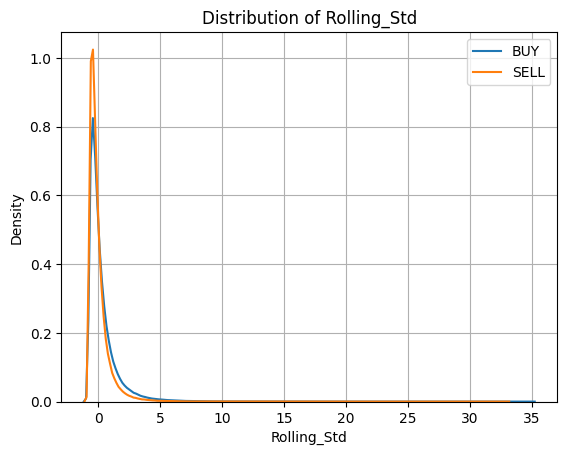

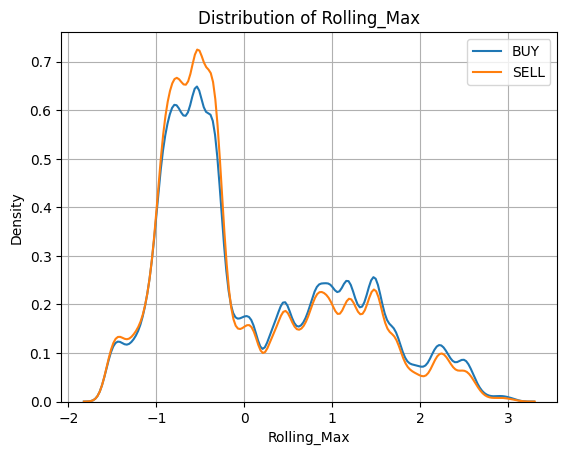

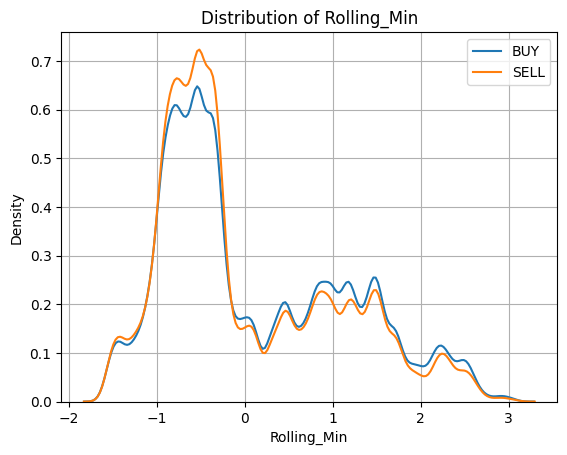

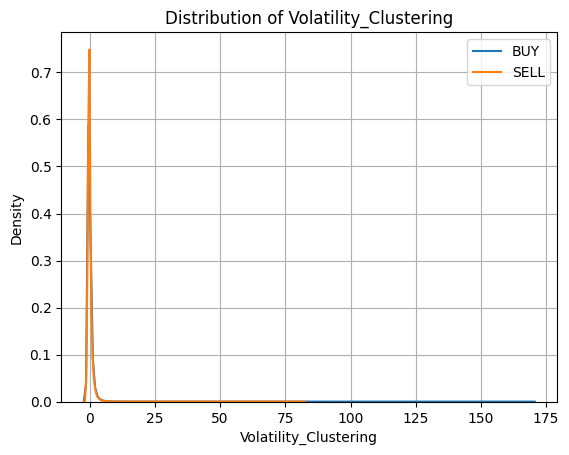

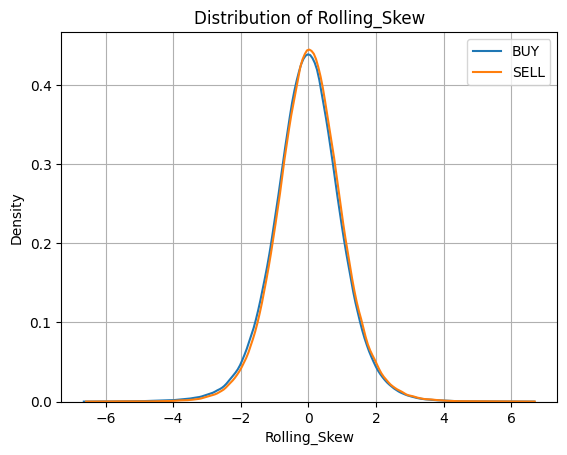

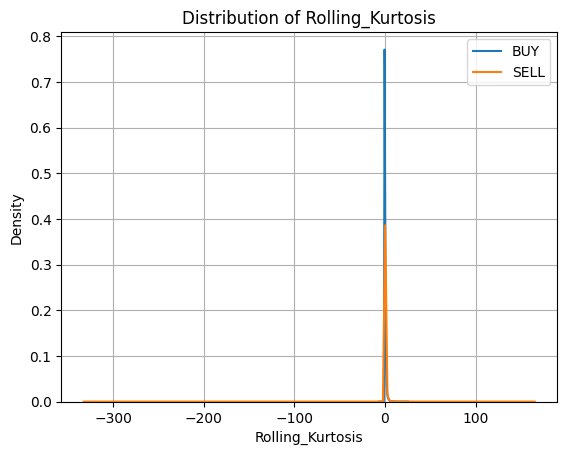

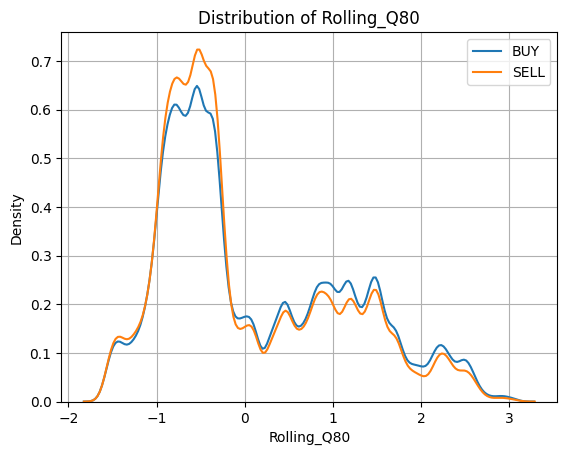

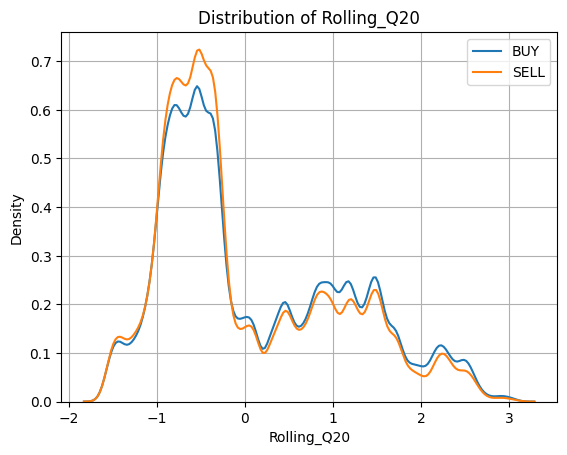

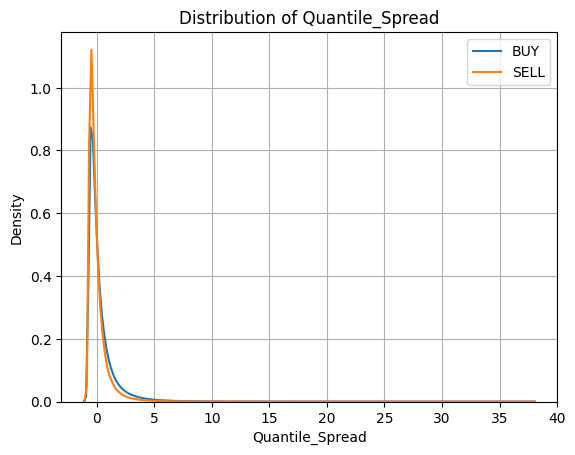

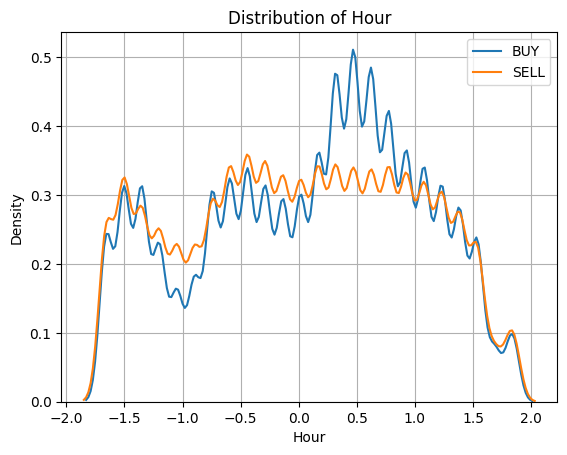

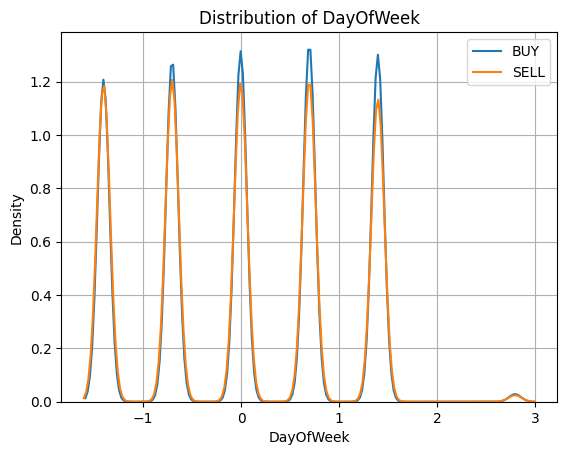

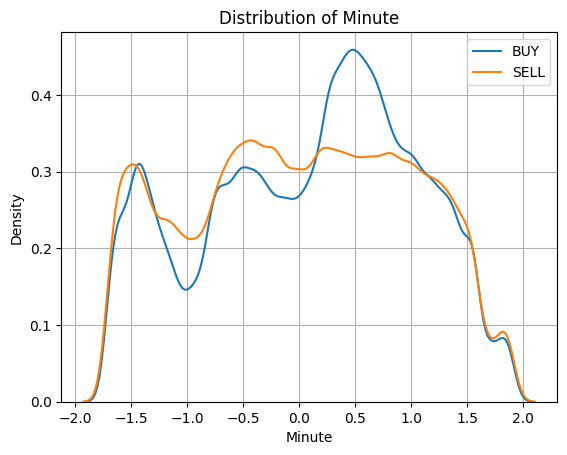

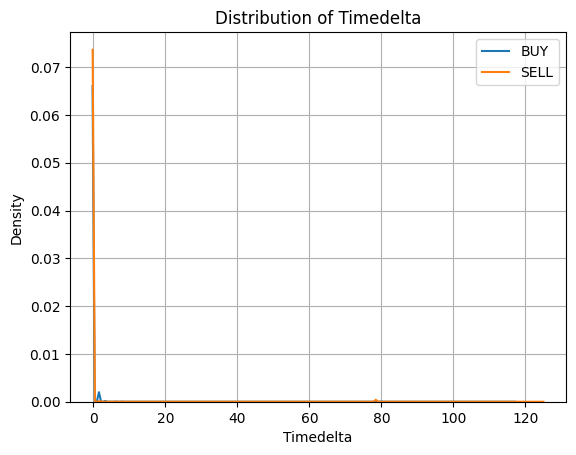

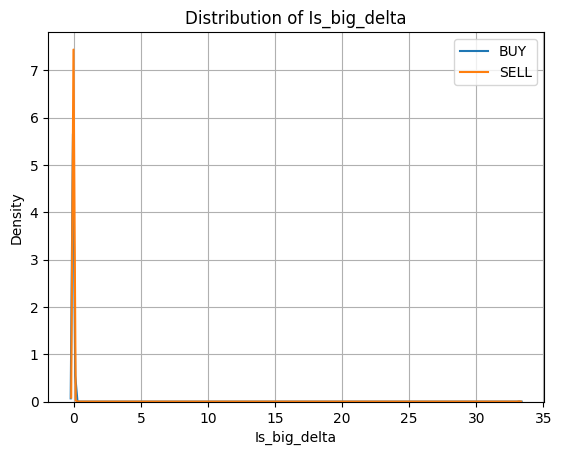

In [14]:
def visualize_kde(df, start_dt=None, end_dt=None):
    df = df.copy()
    if start_dt and end_dt:
        start_dt = pd.to_datetime(start_dt)
        end_dt = pd.to_datetime(end_dt)
        df = df[(df['Datetime'] >= start_dt) & (df['Datetime'] <= end_dt)]
        
    buy = df[df['Label'] == 'BUY']
    sell = df[df['Label'] == 'SELL']

    feature_cols = [col for col in df.columns if col not in ['Label', 'Datetime']]
        
    for col in feature_cols:
        sns.kdeplot(buy[col], label='BUY')
        sns.kdeplot(sell[col], label='SELL')
        plt.title(f'Distribution of {col}')
        plt.legend()
        plt.grid(True)
        plt.show()

visualize_kde(train_df)

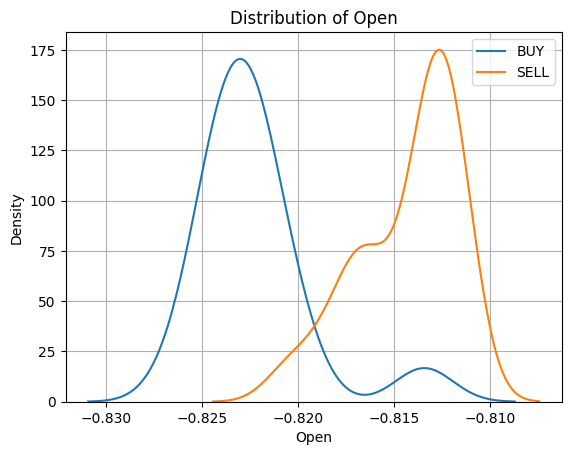

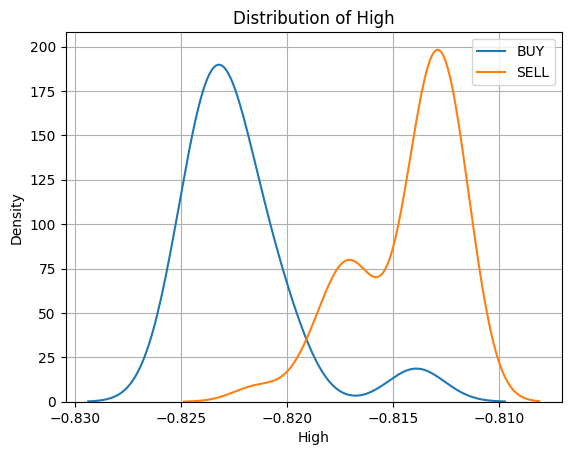

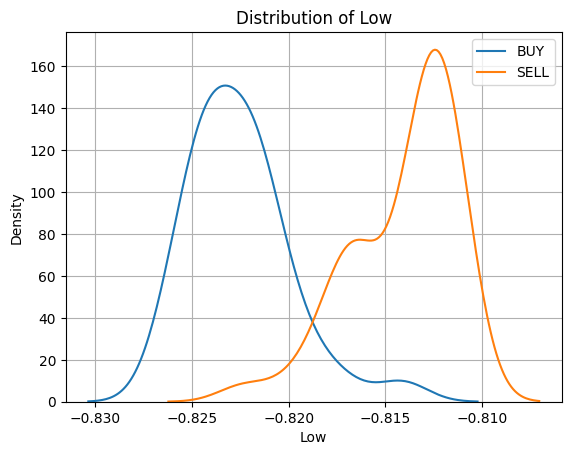

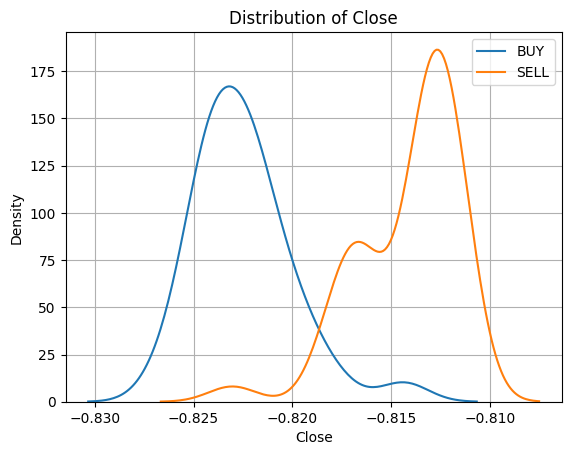

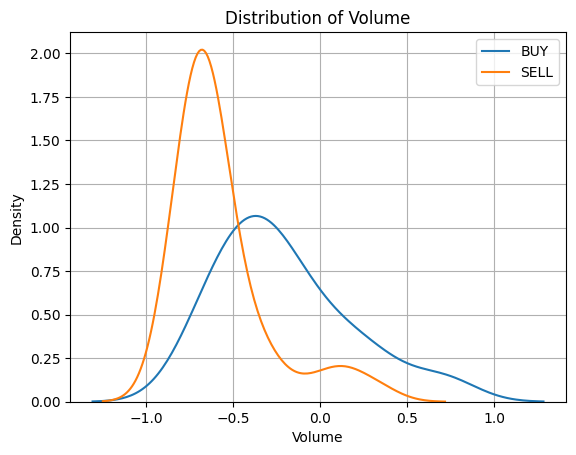

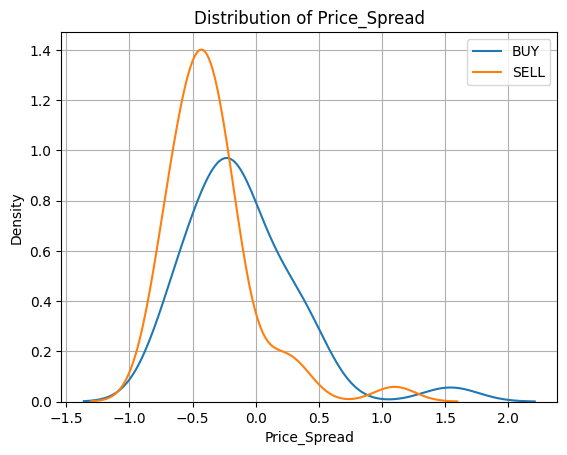

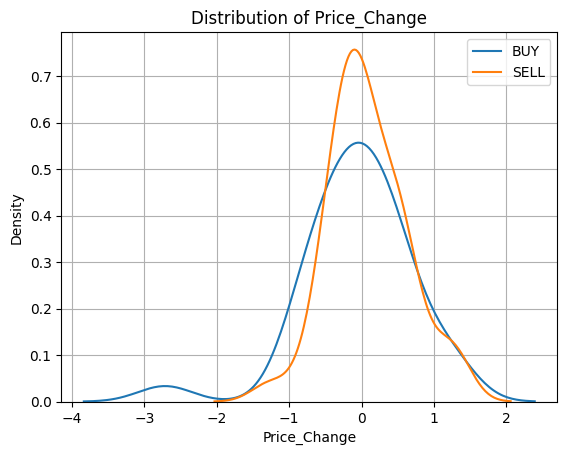

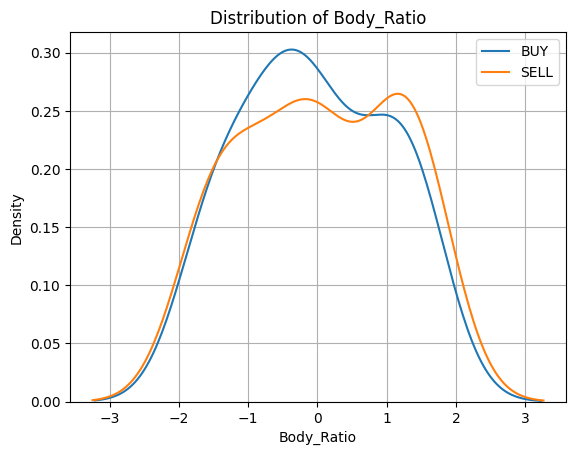

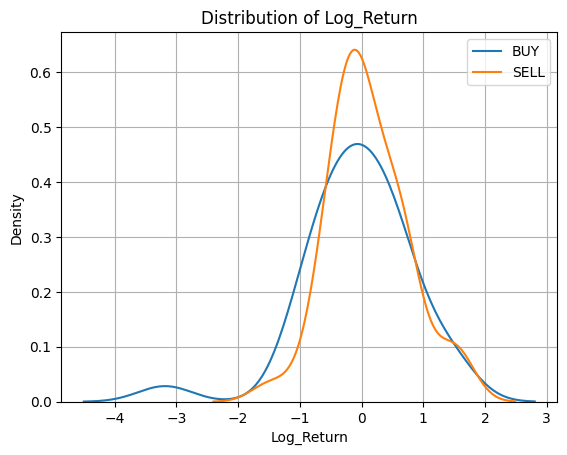

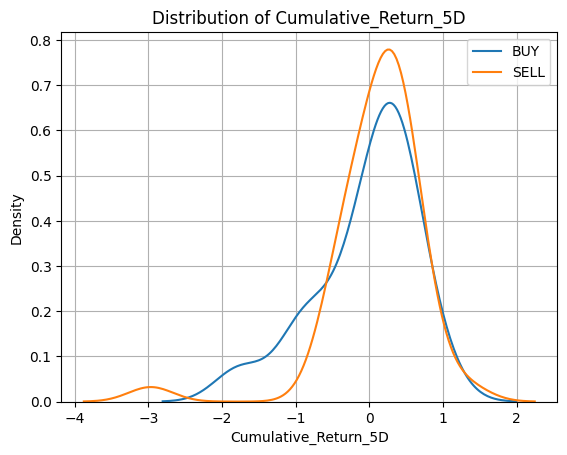

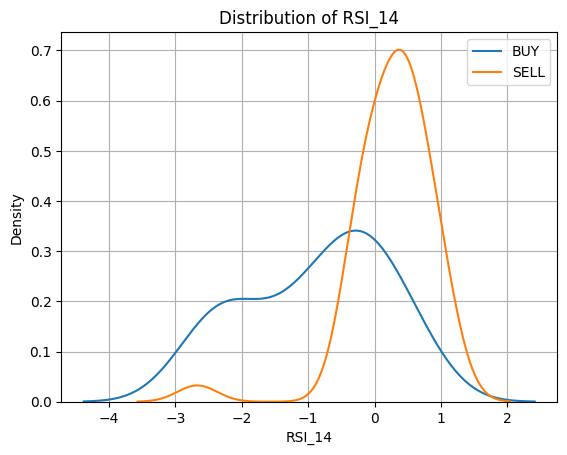

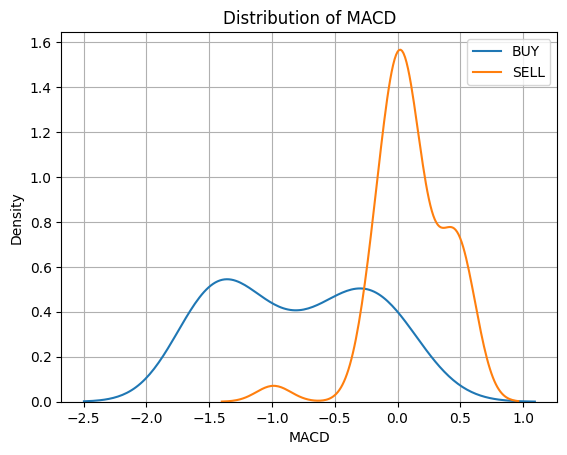

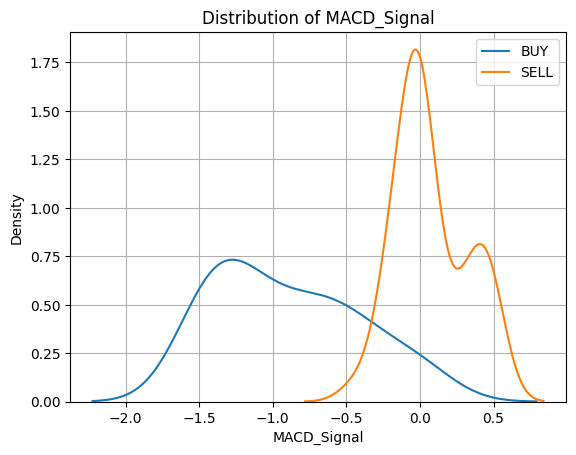

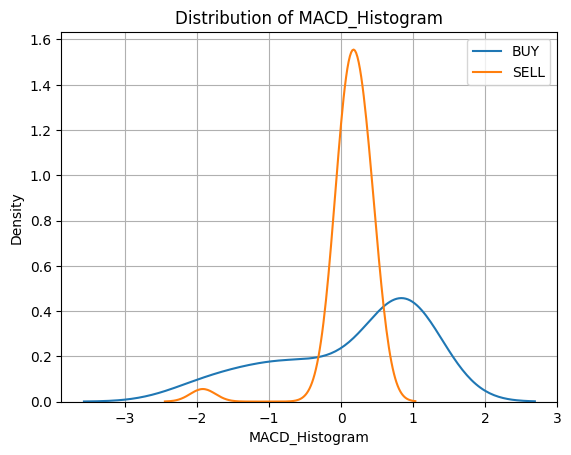

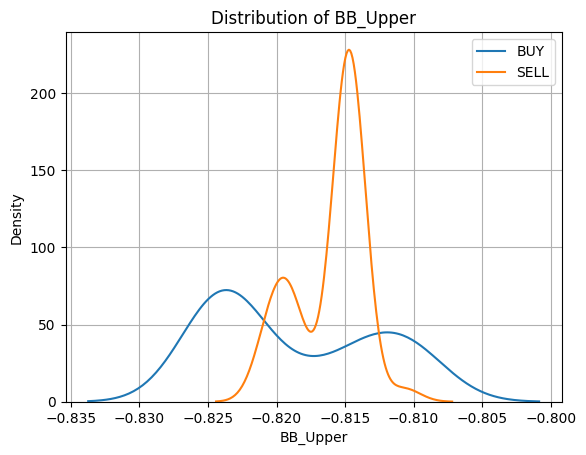

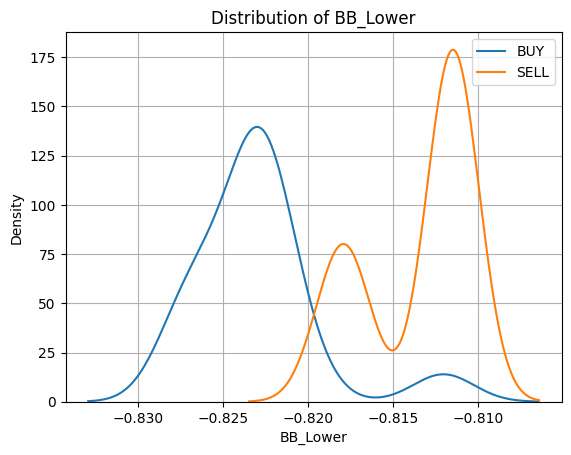

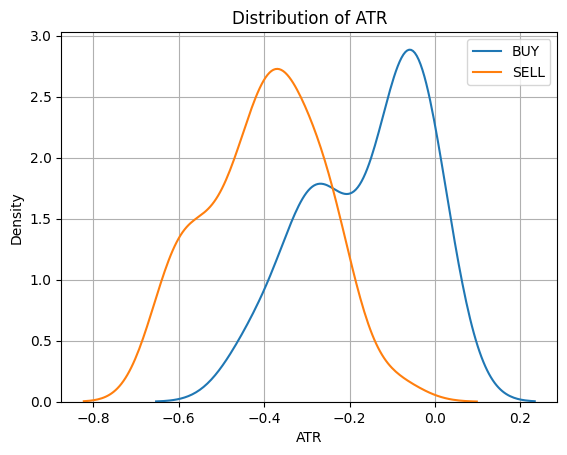

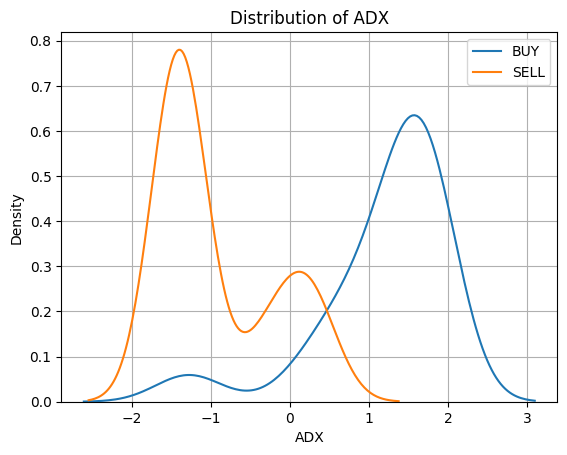

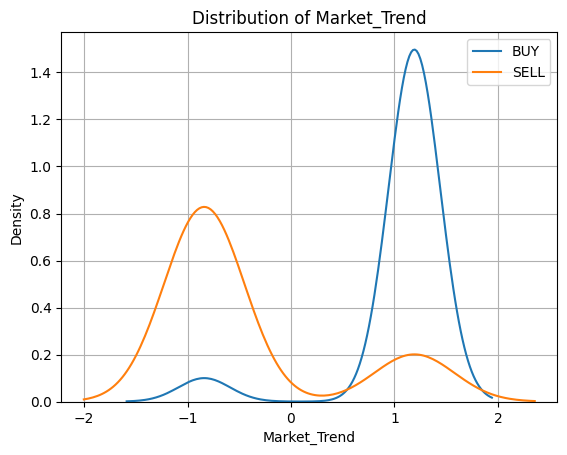

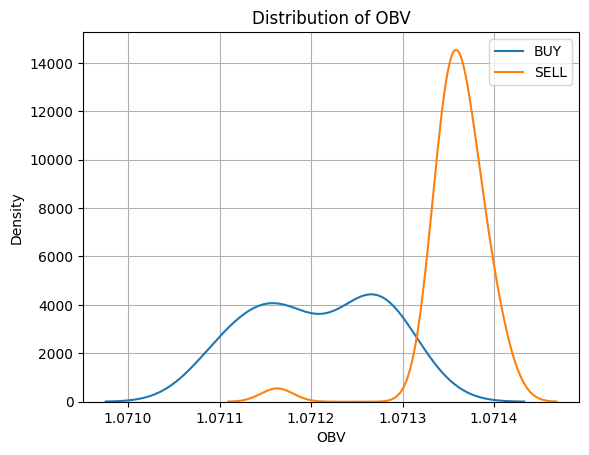

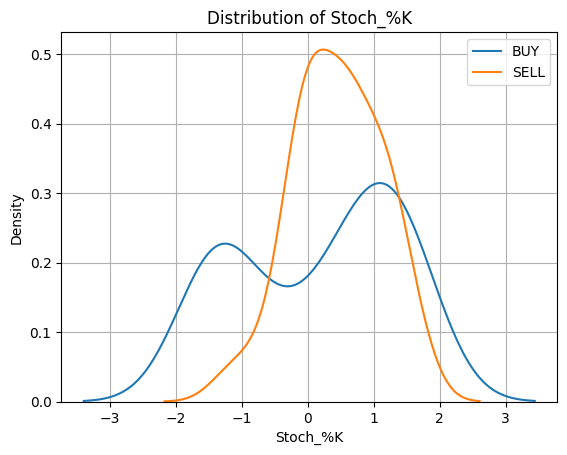

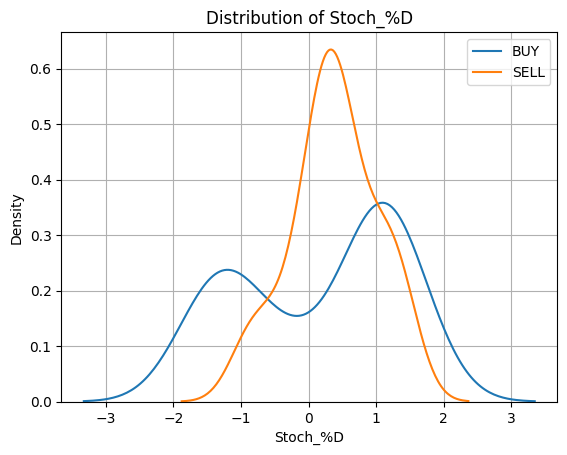

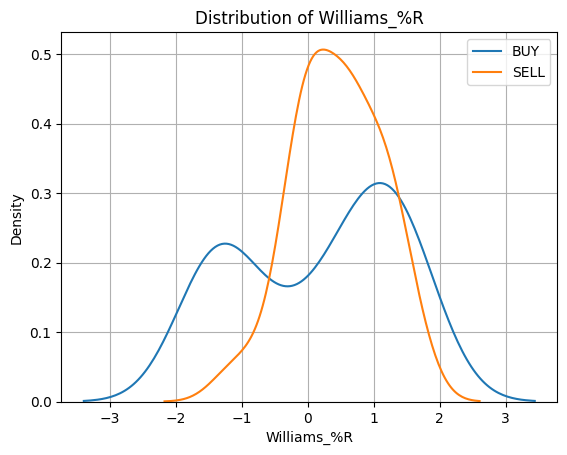

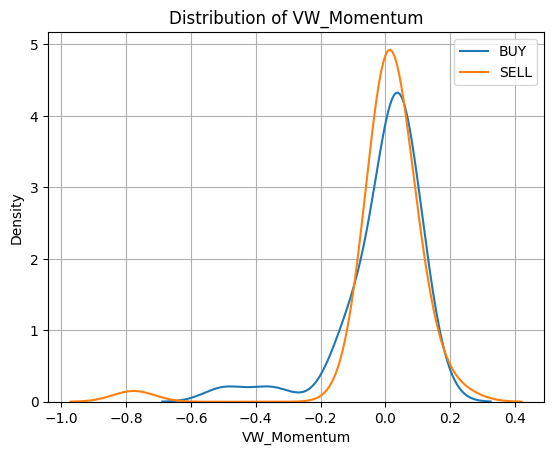

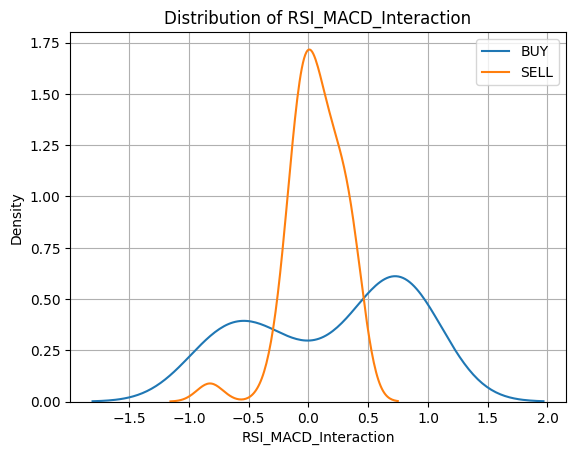

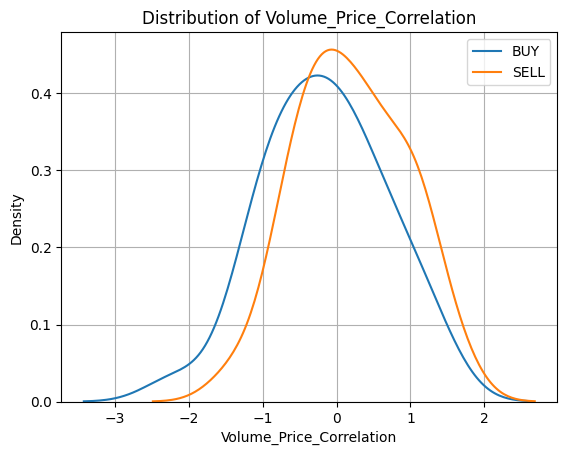

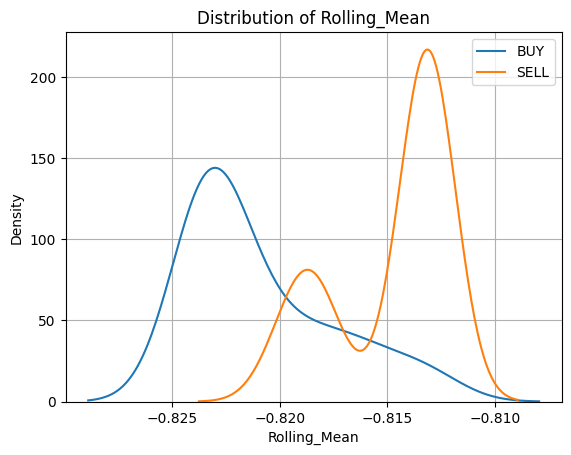

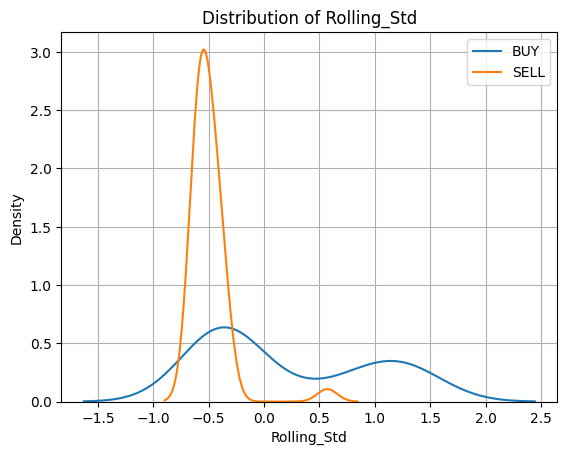

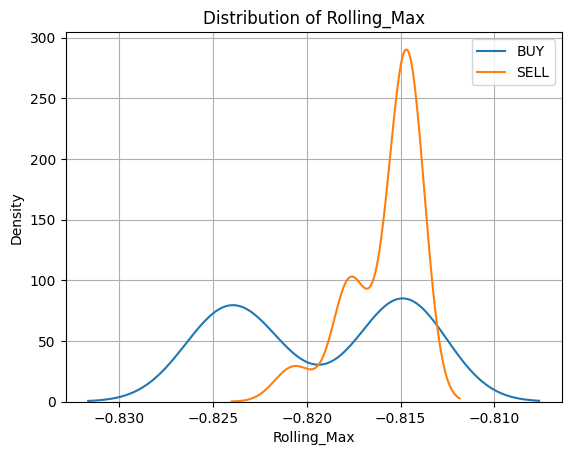

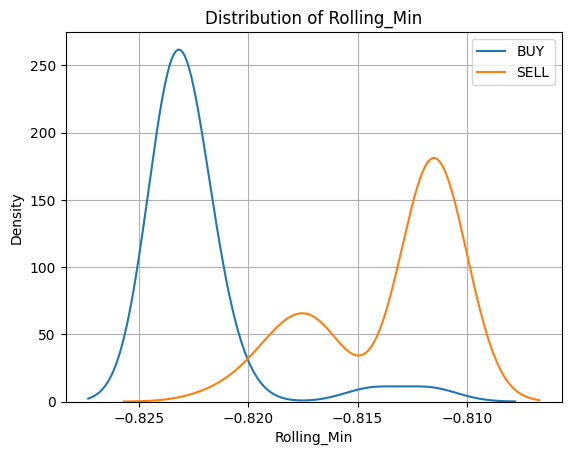

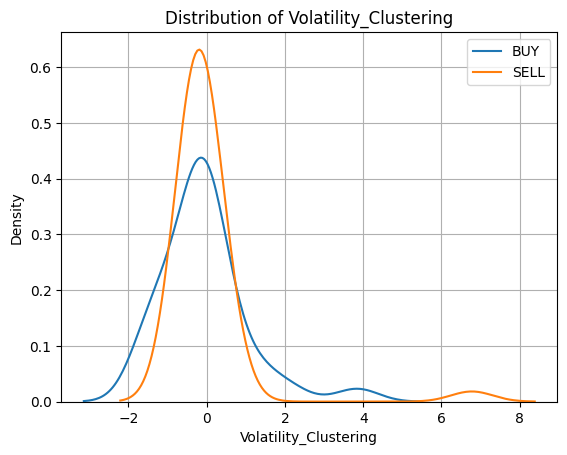

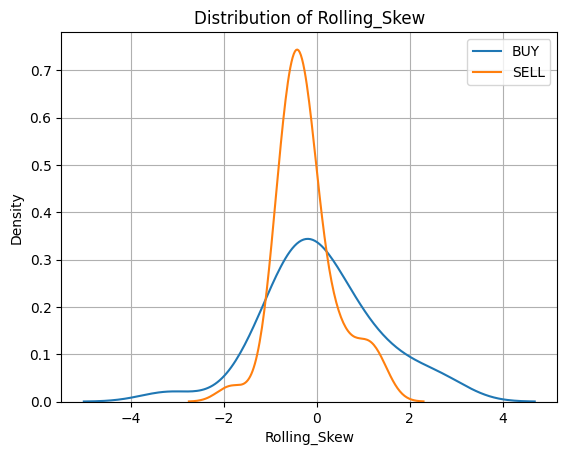

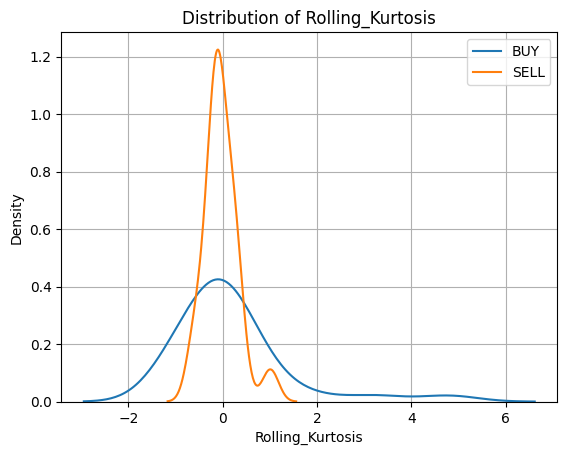

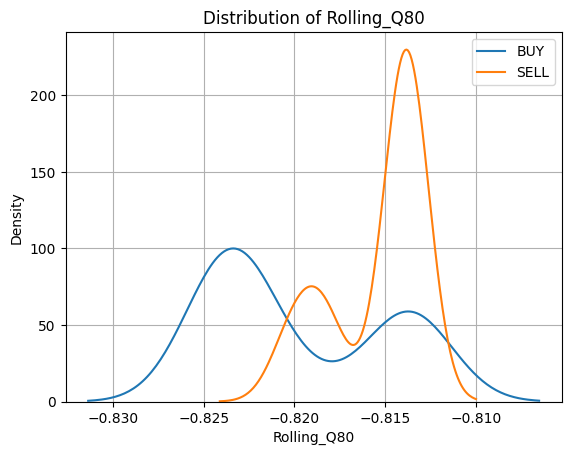

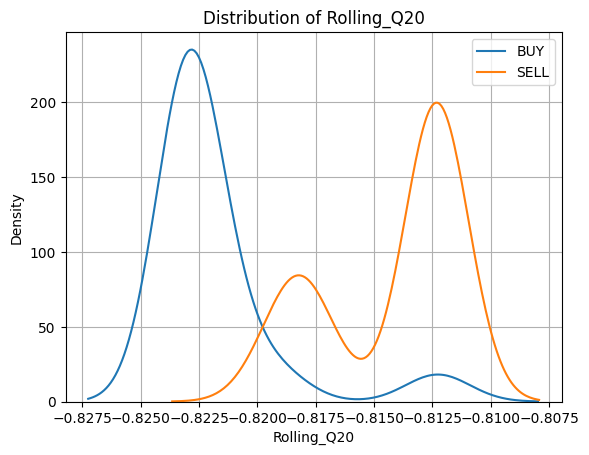

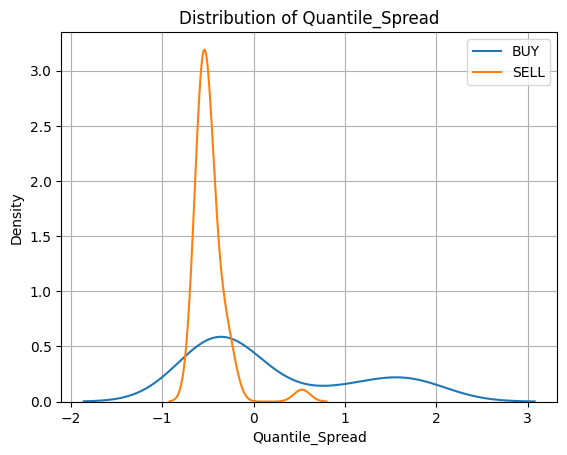

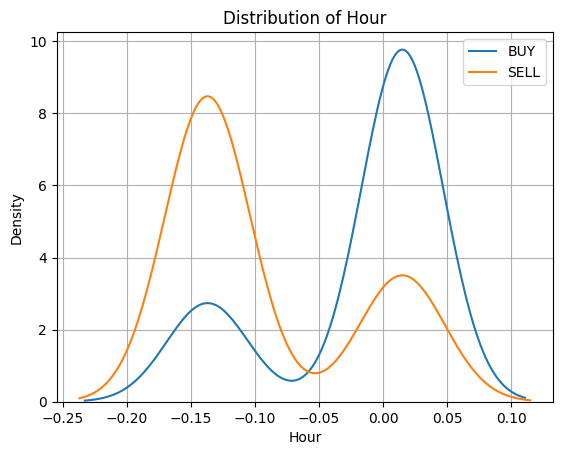

C:\Users\longt\AppData\Local\Temp\ipykernel_20396\1644597433.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(buy[col], label='BUY')
C:\Users\longt\AppData\Local\Temp\ipykernel_20396\1644597433.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(sell[col], label='SELL')
C:\Users\longt\AppData\Local\Temp\ipykernel_20396\1644597433.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


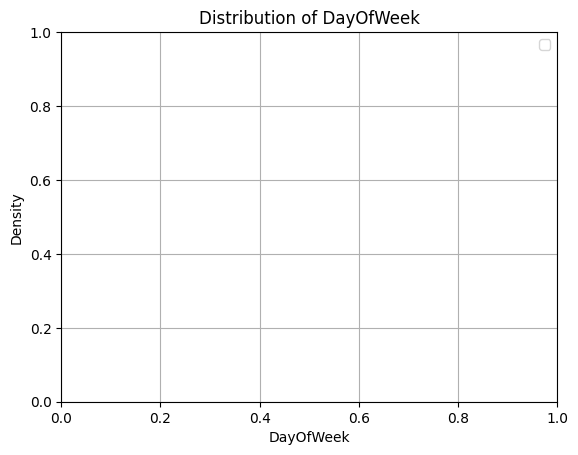

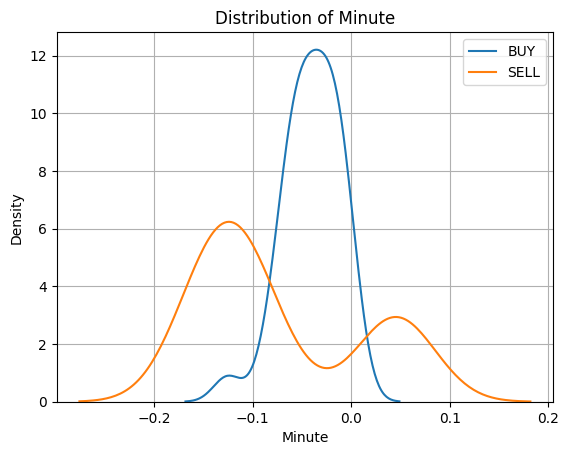

C:\Users\longt\AppData\Local\Temp\ipykernel_20396\1644597433.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(buy[col], label='BUY')
C:\Users\longt\AppData\Local\Temp\ipykernel_20396\1644597433.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(sell[col], label='SELL')
C:\Users\longt\AppData\Local\Temp\ipykernel_20396\1644597433.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


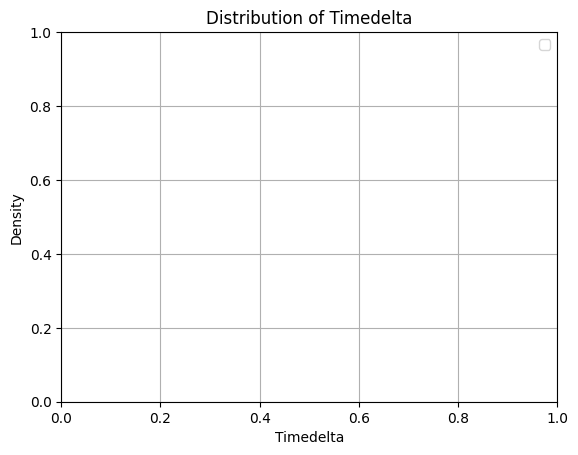

C:\Users\longt\AppData\Local\Temp\ipykernel_20396\1644597433.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(buy[col], label='BUY')
C:\Users\longt\AppData\Local\Temp\ipykernel_20396\1644597433.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(sell[col], label='SELL')
C:\Users\longt\AppData\Local\Temp\ipykernel_20396\1644597433.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


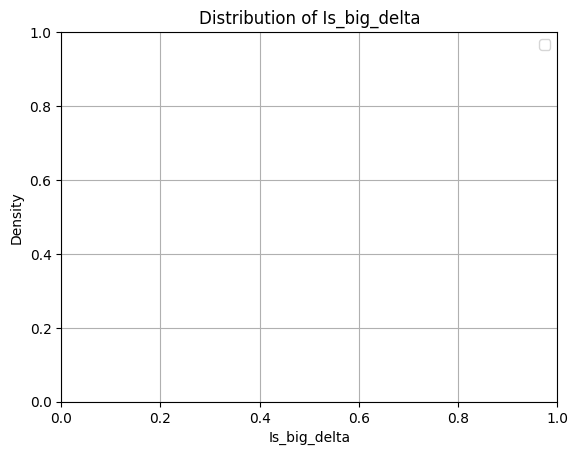

In [15]:
start_dt = '2018-11-20 10:00:00'
end_dt = '2018-11-20 12:00:00'

visualize_kde(train_df, start_dt, end_dt)

In [16]:
from sklearn.feature_selection import mutual_info_classif

def compute_mi(df):
    df = df.copy()
    
    df_binary = df[df['Label'].isin(['BUY', 'SELL'])]
    X = df_binary.drop(columns=['Label', 'Datetime'])
    y = df_binary['Label']

    mi = mutual_info_classif(X, y, discrete_features=False)
    mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    print(mi_series)
    
compute_mi(train_df)

Rolling_Q80                 0.127634
Rolling_Q20                 0.123790
Rolling_Max                 0.114072
Market_Trend                0.111541
Rolling_Min                 0.107782
OBV                         0.093129
DayOfWeek                   0.037009
Log_Return                  0.023320
Body_Ratio                  0.019774
RSI_14                      0.019032
Price_Change                0.018603
BB_Upper                    0.016464
BB_Lower                    0.015506
Cumulative_Return_5D        0.013841
Price_Spread                0.013579
ATR                         0.013292
Rolling_Std                 0.012371
Hour                        0.011782
Williams_%R                 0.011331
Rolling_Mean                0.010549
Stoch_%K                    0.010448
Low                         0.010024
High                        0.009792
Close                       0.009479
Is_big_delta                0.009415
Quantile_Spread             0.009271
VW_Momentum                 0.008997
M

In [17]:
def corr_with_bin(df):
    df = df.copy()
    
    df_binary = df[df['Label'].isin(['BUY', 'SELL'])]
    X = df_binary.drop(columns=['Label', 'Datetime'])
    y = df_binary['Label']
    
    df_binary['Label_num'] = df_binary['Label'].map({'BUY': 1, 'SELL': 0})
    correlations = df_binary.drop(columns=['Label', 'Datetime']).corrwith(df_binary['Label_num'])
    print(correlations.abs().sort_values(ascending=False))
    
corr_with_bin(train_df)

C:\Users\longt\AppData\Local\Temp\ipykernel_20396\446875994.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary['Label_num'] = df_binary['Label'].map({'BUY': 1, 'SELL': 0})


Label_num                   1.000000
ATR                         0.148350
Price_Spread                0.133643
Rolling_Std                 0.124029
Quantile_Spread             0.112690
RSI_14                      0.081364
Volume                      0.079076
Log_Return                  0.074886
Price_Change                0.073746
Williams_%R                 0.063091
Stoch_%K                    0.063091
Cumulative_Return_5D        0.062607
MACD                        0.056222
Stoch_%D                    0.051778
MACD_Signal                 0.047963
BB_Upper                    0.047573
Rolling_Max                 0.047546
Volume_Price_Correlation    0.047250
Rolling_Q80                 0.047233
Rolling_Mean                0.046968
High                        0.046809
Open                        0.046750
Rolling_Q20                 0.046710
Close                       0.046596
Low                         0.046523
BB_Lower                    0.046359
Rolling_Min                 0.046274
B